# Incomplete Data 

Creating accurate predictions is one of the most valuable skills in the job market today. Statisticians, economists, and data scientists use data gathered from specific populations in order to predict the future. Through computational and statistical techniques, we can make _statistical inferences_ to draw conclusions from data that are often incomplete.

As far as estimations of parameters that already exist, having full population data would mean that our questions about that population are answered. But because the cost of gathering a full set of information typically outweigh the benefits of having perfectly accurate data, we are okay with use data samples to draw inferences about past data and predict future observations. 

## Are Mutual Funds better than Broad-market index funds? 

The term “index fund” refers to the investment approach of a fund. Specifically, it is a fund that that aims to match the performance of a particular market index, such as the S&P 500 or Russell 2,000. The index fund simply tries to match the market. This differs from a more actively managed fund, in which investments are picked by a fund manager in an attempt to beat the market. The age old question is: are the fees payed to an actively-managed mutual fund worth it? 

We could simply compare the mean return from a given date range for a mutual fund and compare it to the S&P500s mean return from the same time interval, and see which is higher. But the fact that mutual funds have a limited number of time intervals which we can sample means we cannnot rule out the possibility that higher or lower returns from the fund were a result of random variation, and not an indicator of the true quality of the fund. Returns to investment in the S&P500 is a quality proxy for returns in equity markets. Although returns to the S&P 500 experience stochasticity, on average the average rate of return from a mutual fund data should beat S&P returns on average if active investment is actually improving the rate of return. So, we need to analyze the two funds using statistical techniques which account for random variation that is possible from incomplete data. 

We would like to ananlyze which(if any) mutual funds have out-performed the market, fees included. To start, we read the CSV downloaded from [Stock Market MBA](https://stockmarketmba.com/listoftop100activelymanagedusstockmutualfunds.php), which shows the 100 largest actively-managed mutual funds in the US. 

In [3]:
import numpy as np
import pandas as pd

mutual_fund_data = pd.read_csv("Top100MutualFunds.csv")
mutual_fund_data

,Symbol,Name,Category1,Category2,Category3,Morningstar Category,Morningstar Rating,Market cap,Current yield,Fees,Action
0,AGTHX,American Funds The Growth Fund of America Class A,US Equity,Broad market,Large cap,Large Growth,3.0,"$138,592,080,000",0.22%,0.62%,Analyze
1,FCNTX,Fidelity Contrafund Fund,US Equity,Broad market,Large cap,Large Growth,3.0,"$121,762,870,000",0.00%,0.74%,Analyze
2,CWMAX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",1.46%,0.63%,Analyze
3,CWMCX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",0.79%,1.40%,Analyze
4,CWMEX,American Funds Washington Mutual Investors Fun...,US Equity,Broad market,Large cap,Large Blend,3.0,"$113,300,000,000",1.28%,0.87%,Analyze
...,...,...,...,...,...,...,...,...,...,...,...
95,FDTRX,Franklin DynaTech Fund Class R6,US Equity,Broad market,Large cap,Large Growth,5.0,"$9,600,000,000",0.00%,0.51%,Analyze
96,FDYZX,Franklin DynaTech Fund Advisor Class,US Equity,Broad market,Large cap,Large Growth,5.0,"$9,600,000,000",0.00%,0.62%,Analyze
97,BBVLX,Bridge Builder Large Cap Value Fund,US Equity,Broad market,Large cap,Large Value,4.0,"$9,500,000,000",1.55%,0.25%,Analyze
98,PEYAX,Putnam Large Cap Value Fund Class A,US Equity,Broad market,Large cap,Large Value,4.0,"$9,393,340,000",1.23%,0.91%,Analyze


We don't need to include every category for each fund. Let's drop all categories except for the Morningstar Category. We'll also drop the Morningstar Rating and Action columns.

In [6]:
to_drop = [
    "Category2", "Category1", "Category3", "Morningstar Rating",
    "Current yield", "Action"
]
mutual_fund_data = mutual_fund_data.drop(columns=to_drop)
mutual_fund_data.head()

,Symbol,Name,Morningstar Category,Market cap,Fees
0,AGTHX,American Funds The Growth Fund of America Class A,Large Growth,"$138,592,080,000",0.62%
1,FCNTX,Fidelity Contrafund Fund,Large Growth,"$121,762,870,000",0.74%
2,CWMAX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.63%
3,CWMCX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",1.40%
4,CWMEX,American Funds Washington Mutual Investors Fun...,Large Blend,"$113,300,000,000",0.87%


The symbols column from *mutual_fund_data* contains the ticker symbol that we can use to download data from each fund.  If you have not yet done so, install the module using:

In [7]:
#!pip install pandas-datareader

Next we need to prepare to download the data. We can save the list of symbols and pass each symbol to pandas_datareader. We also need to choose the range of dates to include. Finally, we will save each fund in a dictionary using the ticker sympol as the key for data for that symbol.

In [8]:
import pandas_datareader as web
import datetime as dt

mutual_fund_dict = {}
symbols = mutual_fund_data["Symbol"]

start = dt.datetime(2000, 1, 1)
end = dt.datetime.today()
(start, end, symbols)

(datetime.datetime(2000, 1, 1, 0, 0),
 datetime.datetime(2022, 7, 26, 16, 41, 16, 804170),
 0     AGTHX
 1     FCNTX
 2     CWMAX
 3     CWMCX
 4     CWMEX
       ...  
 95    FDTRX
 96    FDYZX
 97    BBVLX
 98    PEYAX
 99    TWCGX
 Name: Symbol, Length: 100, dtype: object)

Now we are ready to download the data. 

In [11]:
#pull mutual fund data for our chosen timeframe
fund_data = web.DataReader(
    symbols, 
    'yahoo', 
    start=start,
    end=end) 

Display the DataFrame we just made: 

In [12]:
fund_data

Attributes  Adj Close                                                         \
Symbols         AGTHX      FCNTX      CWMAX      CWMCX      CWMEX      CWMFX   
Date                                                                           
2000-01-03  10.563420   2.081266        NaN        NaN        NaN        NaN   
2000-01-04  10.169751   2.006934        NaN        NaN        NaN        NaN   
2000-01-05  10.023950   1.995309        NaN        NaN        NaN        NaN   
2000-01-06   9.980212   1.981571        NaN        NaN        NaN        NaN   
2000-01-07  10.239008   2.021378        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2022-07-19  54.099998  13.920000  51.590000  51.259998  51.209999  51.400002   
2022-07-20  54.720001  14.080000  51.529999  51.189999  51.150002  51.340000   
2022-07-21  55.529999  14.200000  51.770000  51.439999  51.400002  51.580002   
2022-07-22  54.580002  13.940000  51.480000  51.139999  51.099998  51.290001   
2022-07-25  54.580002  13.950000  51.770000  51.430000  51.400002  51.580002   

Attributes                                              ... Volume        \
Symbols         AIVSX      AWSHX      ANCFX      AMCFX  ...  CMGIX SBLYX   
Date                                                    ...                
2000-01-03   9.277543   9.334913  11.380612        NaN  ...    0.0   0.0   
2000-01-04   9.002722   9.092577  11.080562        NaN  ...    0.0   0.0   
2000-01-05   8.973790   9.186281  11.087622        NaN  ...    0.0   0.0   
2000-01-06   9.005614   9.351076  11.137043        NaN  ...    0.0   0.0   
2000-01-07   9.190762   9.551411  11.355899        NaN  ...    0.0   0.0   
...               ...        ...        ...        ...  ...    ...   ...   
2022-07-19  41.880001  51.740002  60.930000  31.500000  ...    0.0   0.0   
2022-07-20  42.009998  51.680000  61.160000  31.879999  ...    0.0   0.0   
2022-07-21  42.360001  51.919998  61.599998  32.340000  ...    0.0   0.0   
2022-07-22  41.939999  51.630001  60.990002  31.809999  ...    0.0   0.0   
2022-07-25  42.049999  51.930000  61.240002  31.760000  ...    0.0   0.0   

Attributes                                                  
Symbols    AKRIX MFEGX FDNRX FDTRX FDYZX BBVLX PEYAX TWCGX  
Date                                                        
2000-01-03   NaN   0.0   NaN   NaN   NaN   NaN   0.0   0.0  
2000-01-04   NaN   0.0   NaN   NaN   NaN   NaN   0.0   0.0  
2000-01-05   NaN   0.0   NaN   NaN   NaN   NaN   0.0   0.0  
2000-01-06   NaN   0.0   NaN   NaN   NaN   NaN   0.0   0.0  
2000-01-07   NaN   0.0   NaN   NaN   NaN   NaN   0.0   0.0  
...          ...   ...   ...   ...   ...   ...   ...   ...  
2022-07-19   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-07-20   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-07-21   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-07-22   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-07-25   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5676 rows x 600 columns]

As we can see, there are many null values for the earlier dates of the DataFrame because many of the funds did not exist in 1980. For aesthetic purposes, we can use the df.tail() method to only show the last 5 rows from now on. 

In [14]:
# there will be many null values at the head of the df so use the .tail() method for the last 5 rows 
fund_data.tail()

Attributes  Adj Close                                                     \
Symbols         AGTHX  FCNTX      CWMAX      CWMCX      CWMEX      CWMFX   
Date                                                                       
2022-07-19  54.099998  13.92  51.590000  51.259998  51.209999  51.400002   
2022-07-20  54.720001  14.08  51.529999  51.189999  51.150002  51.340000   
2022-07-21  55.529999  14.20  51.770000  51.439999  51.400002  51.580002   
2022-07-22  54.580002  13.94  51.480000  51.139999  51.099998  51.290001   
2022-07-25  54.580002  13.95  51.770000  51.430000  51.400002  51.580002   

Attributes                                              ... Volume        \
Symbols         AIVSX      AWSHX      ANCFX      AMCFX  ...  CMGIX SBLYX   
Date                                                    ...                
2022-07-19  41.880001  51.740002  60.930000  31.500000  ...    0.0   0.0   
2022-07-20  42.009998  51.680000  61.160000  31.879999  ...    0.0   0.0   
2022-07-21  42.360001  51.919998  61.599998  32.340000  ...    0.0   0.0   
2022-07-22  41.939999  51.630001  60.990002  31.809999  ...    0.0   0.0   
2022-07-25  42.049999  51.930000  61.240002  31.760000  ...    0.0   0.0   

Attributes                                                  
Symbols    AKRIX MFEGX FDNRX FDTRX FDYZX BBVLX PEYAX TWCGX  
Date                                                        
2022-07-19   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-07-20   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-07-21   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-07-22   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  
2022-07-25   0.0   0.0   0.0   0.0   0.0   0.0   0.0   0.0  

[5 rows x 600 columns]

The column names have two layers. We are interested in the adjusted close data. Save this data as a unique dataframe, *close_data*, by selecting the key "Adj Close" from *fund_data*.

In [15]:
close_data = fund_data["Adj Close"]
close_data.tail()

Symbols,AGTHX,FCNTX,CWMAX,CWMCX,CWMEX,CWMFX,AIVSX,AWSHX,ANCFX,AMCFX,...,CMGIX,SBLYX,AKRIX,MFEGX,FDNRX,FDTRX,FDYZX,BBVLX,PEYAX,TWCGX
Date,,,,,,,,,,,,,,,,,,,,,
2022-07-19,54.099998,13.92,51.590000,51.259998,51.209999,51.400002,41.880001,51.740002,60.930000,31.500000,...,32.299999,53.619999,53.700001,132.559998,98.589996,108.190002,106.779999,15.59,28.660000,39.119999
2022-07-20,54.720001,14.08,51.529999,51.189999,51.150002,51.340000,42.009998,51.680000,61.160000,31.879999,...,33.040001,54.610001,54.049999,134.259995,100.639999,110.440002,109.000000,15.59,28.650000,39.619999
2022-07-21,55.529999,14.20,51.770000,51.439999,51.400002,51.580002,42.360001,51.919998,61.599998,32.340000,...,33.529999,55.389999,54.830002,136.520004,103.160004,113.209999,111.730003,15.68,28.809999,40.150002
2022-07-22,54.580002,13.94,51.480000,51.139999,51.099998,51.290001,41.939999,51.630001,60.990002,31.809999,...,33.040001,54.439999,54.500000,134.389999,101.099998,110.949997,109.500000,15.63,28.660000,39.520000
2022-07-25,54.580002,13.95,51.770000,51.430000,51.400002,51.580002,42.049999,51.930000,61.240002,31.760000,...,32.770000,54.160000,54.330002,133.800003,100.489998,110.279999,108.839996,15.72,28.850000,39.389999


We will want to compare the returns earned by each fund to the returns earned by investment in the S&P 500 index. We will save the S&P 500 data as a new column in the same data frame, *close_data*.

In [16]:
close_data["S&P 500"] = web.DataReader(
    '^GSPC', 
    'yahoo', 
    start=start,
    end=end)['Adj Close']

<ipython-input-16-96a3e63cb6d0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  close_data["S&P 500"] = web.DataReader(


In [18]:
close_data["S&P 500"].tail()

Date
2022-07-19    3936.689941
2022-07-20    3959.899902
2022-07-21    3998.949951
2022-07-22    3961.629883
2022-07-25    3966.840088
Name: S&P 500, dtype: float64

Since data for many of the funds considered do not span many years, we will compare monthly returns for each fund to monthly returns to the S&P 500.

To do this, we use the Pandas _.resample("M")_ method, with the "M" specifying that we would like a monthly frequency. Then, we take the _.pct_change()_ on our monthly data.  

In [19]:
monthly_close_data = close_data.resample("M").first()
monthly_close_data.tail()

Symbols,AGTHX,FCNTX,CWMAX,CWMCX,CWMEX,CWMFX,AIVSX,AWSHX,ANCFX,AMCFX,...,SBLYX,AKRIX,MFEGX,FDNRX,FDTRX,FDYZX,BBVLX,PEYAX,TWCGX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-31,63.310001,15.92,56.189808,55.880783,55.815437,55.977024,46.325485,54.471134,67.268890,39.240002,...,62.799999,56.330002,151.059998,119.370003,130.669998,129.029999,16.564430,29.836908,45.346741,4306.259766
2022-04-30,66.730003,16.75,59.119999,58.759998,58.709999,58.900002,48.621357,57.306664,70.164452,40.450001,...,65.980003,59.400002,158.410004,124.720001,136.600006,134.880005,17.260000,31.196695,47.830002,4545.859863
2022-05-31,59.130001,14.90,55.540001,55.169998,55.139999,55.349998,44.445953,53.845840,64.477814,36.130001,...,57.590000,54.560001,140.020004,106.339996,116.529999,115.050003,16.320000,29.750557,42.119999,4155.379883
2022-06-30,56.630001,14.50,56.090000,55.680000,55.680000,55.900002,44.583496,54.377529,64.409424,34.779999,...,54.439999,54.009998,136.559998,101.410004,111.190002,109.760002,16.549999,30.189386,39.980000,4101.229980
2022-07-31,52.220001,13.40,50.919998,50.610001,50.560001,50.730000,41.220001,51.070000,59.200001,30.430000,...,50.730000,51.669998,128.339996,94.860001,104.070000,102.720001,15.360000,28.170000,37.520000,3825.330078


In [20]:
#calculate percent change from previous month
monthly_returns = monthly_close_data.pct_change()
monthly_returns.tail()

Symbols,AGTHX,FCNTX,CWMAX,CWMCX,CWMEX,CWMFX,AIVSX,AWSHX,ANCFX,AMCFX,...,SBLYX,AKRIX,MFEGX,FDNRX,FDTRX,FDYZX,BBVLX,PEYAX,TWCGX,S&P 500
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-31,-0.064154,-0.073103,-0.033259,-0.033834,-0.033328,-0.033201,-0.048471,-0.033168,-0.044970,-0.055141,...,-0.083212,-0.083021,-0.078846,-0.064058,-0.063700,-0.063779,-0.035383,-0.029440,-0.063473,-0.052849
2022-04-30,0.054020,0.052136,0.052148,0.051524,0.051860,0.052217,0.049560,0.052056,0.043045,0.030836,...,0.050637,0.054500,0.048656,0.044819,0.045382,0.045338,0.041992,0.045574,0.054762,0.055640
2022-05-31,-0.113892,-0.110448,-0.060555,-0.061096,-0.060807,-0.060272,-0.085876,-0.060391,-0.081047,-0.106799,...,-0.127160,-0.081481,-0.116091,-0.147370,-0.146925,-0.147020,-0.054461,-0.046355,-0.119381,-0.085898
2022-06-30,-0.042280,-0.026846,0.009903,0.009244,0.009793,0.009937,0.003095,0.009874,-0.001061,-0.037365,...,-0.054697,-0.010081,-0.024711,-0.046361,-0.045825,-0.045980,0.014093,0.014750,-0.050807,-0.013031
2022-07-31,-0.077874,-0.075862,-0.092173,-0.091056,-0.091954,-0.092487,-0.075443,-0.060825,-0.080880,-0.125072,...,-0.068148,-0.043325,-0.060193,-0.064589,-0.064035,-0.064140,-0.071903,-0.066891,-0.061531,-0.067272


Now that we have out data wrangled and prepped, we can compute some basic statistics to understand the distribution of our dataset. The easiest method to start with is using the Pandas _df.describe()_ method, which gives us basic descriptive statistics for each series in our dataframe. 

In [21]:
monthly_returns.describe()

Symbols,AGTHX,FCNTX,CWMAX,CWMCX,CWMEX,CWMFX,AIVSX,AWSHX,ANCFX,AMCFX,...,SBLYX,AKRIX,MFEGX,FDNRX,FDTRX,FDYZX,BBVLX,PEYAX,TWCGX,S&P 500
count,270.000000,270.000000,245.000000,245.000000,245.000000,244.000000,270.000000,270.000000,270.000000,167.000000,...,270.000000,155.000000,270.000000,163.000000,109.000000,170.000000,87.000000,270.000000,270.000000,270.000000
mean,0.007291,0.007965,0.007228,0.006595,0.006875,0.007162,0.006492,0.007300,0.007328,0.009062,...,0.006573,0.012459,0.005856,0.014149,0.012934,0.010254,0.008548,0.007880,0.006006,0.004785
std,0.051824,0.045470,0.044429,0.044377,0.044404,0.044535,0.043429,0.044060,0.048645,0.054516,...,0.053501,0.041805,0.059484,0.057316,0.057707,0.062265,0.050318,0.047293,0.051627,0.048579
min,-0.177993,-0.171806,-0.200029,-0.200387,-0.200425,-0.200126,-0.175103,-0.200075,-0.206320,-0.183176,...,-0.184912,-0.177495,-0.194767,-0.168244,-0.167883,-0.245310,-0.236800,-0.227727,-0.165960,-0.200545
25%,-0.017873,-0.015419,-0.014064,-0.014651,-0.014134,-0.014695,-0.015242,-0.016702,-0.018441,-0.014771,...,-0.022412,-0.009082,-0.024033,-0.022232,-0.022394,-0.024517,-0.008809,-0.012809,-0.020322,-0.020384
50%,0.012503,0.012283,0.014073,0.013387,0.013481,0.013504,0.011594,0.013455,0.013005,0.019387,...,0.011195,0.017508,0.011709,0.020833,0.016931,0.019657,0.011881,0.011628,0.010440,0.010624
75%,0.035442,0.033950,0.030252,0.029754,0.029746,0.030295,0.030098,0.030350,0.032117,0.035831,...,0.038843,0.037518,0.040700,0.050232,0.049334,0.048645,0.030067,0.031835,0.038456,0.031849
max,0.161980,0.164007,0.144078,0.142714,0.143174,0.144218,0.142015,0.144030,0.157740,0.172690,...,0.185804,0.138616,0.223051,0.175044,0.175689,0.175576,0.139442,0.167936,0.163390,0.157330


We can also display a visual of our distributions by using a histogram. Usually, rates of change like we are dealing with in stock prices will display a normal-looking distribution. We can take the mean change of the entire dataset and the mean standard deviation of the entire dataset to be entered into a normal distribution function that we can overlay over our data's histogram to visually check for normality. 

In [22]:
# find the mean of the mean monthly changes and the mean standard deviation of changes
mu = monthly_returns.mean().mean()
sigma = monthly_returns.std().mean()
print(mu, sigma)

0.008422884242020107 0.051363558631453386


Text(0.5, 1.0, 'Distributions of Various Index Fund Returns With Overlayed Normal Distribution')

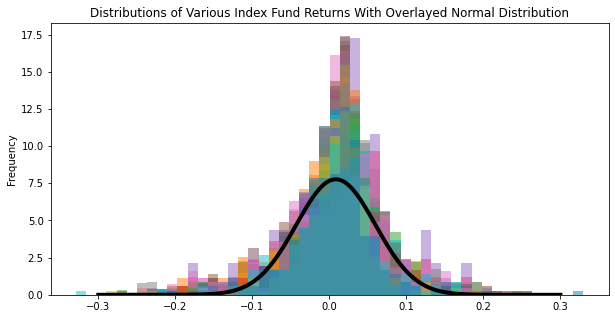

In [26]:
import matplotlib.pyplot as plt
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(10, 5))

#plot the funds distributions
monthly_returns.plot.hist(bins=50, ax=ax, density=True, alpha=.5, legend=False)

#define a line x using np.linspace() so that we can transform the points into a normal distribution
x = np.linspace(-.3, .3, 10000)

#plot the normal distribution using scipy.stats.norm.pdf with the same mean and sttandard deviation as our fund data
ax.plot(x,
        stats.norm.pdf(x, mu, sigma),
        color='k',
        lw=4,
        label="Normal Distribution")

ax.set_title(
    "Distributions of Various Index Fund Returns With Overlayed Normal Distribution"
)

We have successfully wrangled and prepped our data and can now begin statistical analysis on it. 

## Hypothesis Testing

To start, you formulate your __hypotheses__. These are mutually exclusive, falsifiable statements. Only one can be true, and one of them will be true. We create these two hypotheses: 

- The _null_ hypothesis $H_o$: The true means of the the sample populations do not differ.
- The _alternate_ hypothesis $H_a$: The true means of the sample populations do differ.

### 4 Steps of Hypothesis Testing

All hypotheses are tested using a four-step process:

1. State the two hypotheses so that only one can be right. 
2. Formulate an analysis plan, which outlines how the data will be evaluated.
3. Carry out the plan and physically analyze the sample data.
4. Analyze the results and either reject the null hypothesis, or state that the null hypothesis is plausible, given the data.

Hypothesis testing can be done mentally. It would be burdensome to have to state your _null_ and _alternate_ hypotheses, and run through these four steps explicitly every time you made a predictive computer model. The point is that in means testing, there is a clear process and result that deliniates "Yes, the true means of these samples are different" and "No, they're not significantly different"

In the case of us determining the efficacy of an investment strategy, we must compare the return on strategy to the average return approximated by returns on investment in the S&P 500. These are our hypotheses: 

- $H_o$: There is no difference between the mutual fund's and S&P500's average monthly return. 
- $H_a$: The mutual funds have a higher mean gain than the S&P500. 

In particular, we would like to know if the mean returns for any and each index funds are different from and higher than returns earned by the S&P 500.

We can easily calculate the average monthly returns for each fund using the _.mean()_ method. 

In [16]:
avg_monthly_returns = monthly_returns.mean()
avg_monthly_returns

Symbols
AGTHX      0.007291
FCNTX      0.007965
CWMAX      0.007228
CWMCX      0.006595
CWMEX      0.006875
             ...   
FDYZX      0.010254
BBVLX      0.008548
PEYAX      0.007880
TWCGX      0.006006
S&P 500    0.004785
Length: 101, dtype: float64

# Comparisons of Means

When dealing with a population of known parameters $\mu$ and $\sigma^2$, we can take any mean $\bar{X}$ gotten from a sample and determine the likelihood that the sample came from out known population, or a population with same mean as our known population. We do this using a z-score: 
<h3 align="center">
    <font size="5">
        $ z = \frac{\bar{X} - \mu}{\frac{\sigma}{\sqrt(n)}}$
    </font>
</h3>

In [17]:
def zscore(data, mu, sigma):
    x_bar = data.mean()
    n = len(data)
    z = (x_bar - mu) / (sigma / np.sqrt(n))
    return z

Since we pulled all of the S&P data for the relevant time period, we have all of the relevant population data for the S&P and for any other fund. We can, for instance, compare the mean return of the S&P from 1995 to 2000 to the overall mean return of the S&P. 

In [18]:
sp500_1995_2000 = monthly_returns["S&P 500"]['1995':'2000']
sp500_1995_2000

Date
2000-01-31         NaN
2000-02-29   -0.031569
2000-03-31   -0.021351
2000-04-30    0.091924
2000-05-31   -0.025047
2000-06-30   -0.013240
2000-07-31    0.014308
2000-08-31   -0.021394
2000-09-30    0.057486
2000-10-31   -0.055590
2000-11-30   -0.010451
2000-12-31   -0.074577
Freq: M, Name: S&P 500, dtype: float64

Define $\mu$ and $\sigma$ to be the mean S&P monthly return, and the standard deviation of the monthly returns across the whole dataset.

In [19]:
mu = monthly_returns["S&P 500"].mean()
sigma = monthly_returns["S&P 500"].std()

Plug these values into our _zscore_ function, to find how many standard deviations the mean monthly S&P change from 1995-2000 was from the mean for all S&P monthly returns: 

In [20]:
z = zscore(sp500_1995_2000, mu, sigma)
z

-0.9213981994805907

So from 1995 to 2000 the s&P's monthly return was roughly .16 standard deviations higher than it historically has been. We can plug this value into the standard normal distribution to obtain the probability that this outcome would occur if the mean from 1995 to 2000 truly was the same as the historical S&P monthly returns mean. For this, we can use the same normal distribution function we made in chapter 3. 

In [21]:
# define normal distribution function
def normal_dist(mean , sd, x):
    prob_density = 1/(np.pi*sd) * np.exp(-0.5*((x-mean)/sd)**2)
    return prob_density

In [22]:
normal_dist(0, 1, z)

0.20820810245820306

This test suggets that there was a .116 probability of getting this result if the mean monthly S&P return from 1995-2000 truly was the same as the overall mean. This is high, and the general cutoff for "statistical significance" is less than 0.05. So this result is non-significant, and we choose to reject the alternate hypothesis that the S&P had a different mean monthly return from 1995 to 2000 than it had historically. 

## T-values

The t-value, returned from the __T-test__ is used when we are dealing with a population of unknown, but normal, distribution. We have to check this assumption of normality prior to any t-test. Once we have done that, we can compare a given sample mean to one of three options: 

- **One Sample T-test:** The one sample t test compares the mean of your sample data to a known value. For example, we can compare a given funds average monthly return to some arbitrary value, like 7% or 10%. 
<h3 align="center">
    <font size="7">
        $ t = \frac{\bar{X} - \mu}{\frac{s}{\sqrt{n}}}$
    </font>
    </h3> 
    
    
   - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
   - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean

In [23]:
from datlib.stats import *

def t_value_1samp(data, mu):
    x_bar = np.mean(data)
    s = np.std(data)
    n = len(data)
    df = n - 1
    t = (x_bar - mu) / (s / np.sqrt(n))
    return t, df

- **Independent Samples T-test:** The The independent samples t test (also called the unpaired samples t test) is the most common form of the T test. It helps you to compare the means of two sets of data. Normally, we are checking to see if the means of the data are significantly different from a differnece of zero. But , we can also check if they are significantly different from a hypothesized or theoretical value. For instance, say we had two groups of males and one group of females and we wanted to compare average heights between the groups. For the males, we would check to see if they differed significantly from an average height difference of zero, whereas when comparing the males to the females we may want to see if they were significantly different from an average difference of 2 inches, or whatever the average height between males and females is. **This hypothesized difference, $(\mu_1 - \mu_2)$, will usually be zero, but not always.**

<h3 align="center">
    <font size="7">
        $ t = \frac{(\bar{x_1}-\bar{x_2})-(\mu_1 - \mu_2)}{\sqrt{\frac{s^2_1}{n_1}+\frac{s^2_2}{n_2}}}$
    </font>
    </h3> 
    
   
   - Note that this t-test is one variation of the independent samples t-test that _does not_ assume equal variance between the samples
   
    - Null Hypothesis: sample mean is the same as hypothesized or theoretical mean
    - Alternative Hypothesis: sample mean is different from the hypothesized or theoretical mean
    

In [24]:
# independent samples t-test, setting equal_var=True will turn this test into a paired samples t-test where equal variance
# is assumed
def t_value_ind_samp(a, b, hypothesized_difference=0, equal_var=False):
    
    s1 = np.var(a)
    s2 = np.var(b)
    n1 = len(a)
    n2 = len(b)
    
    # if paired samples, df calculation is different
    if (equal_var):
        df = n1 + n2 - 2
        svar = ((n1 - 1) * s1 + (n2 - 1) * s2) / float(df)
        denom = np.sqrt(svar * (1.0 / n1 + 1.0 / n2))
    else:
        vn1 = s1 / n1
        vn2 = s2 / n2
        df = ((vn1 + vn2)**2) / ((vn1**2) / (n1-1) + (vn2**2) / (n2-1))
        denom = np.sqrt(vn1 + vn2)

    d = np.mean(a) - np.mean(b) - hypothesized_difference
    t = d / denom
    return t, df

- **Paired Samples T-test:** A paired t test (also called a correlated pairs t-test, a paired samples t test or dependent samples t test) is where you run a t test on dependent samples. Dependent samples are essentially connected — they are tests on the same person or thing. This would be useful if we chose a random sample of stores and measured their mean revenues before and after implementation of the new marketing campaign as our two means. For our function, we can simply add an optional argument "equal_var" to our independent t-test funtion which will cause it to act like a paired samples t-test. 

## The T Probability Distribution
When comparing two samples drawn from a population with unknown parameters, we return a t-value(defined below) similar to the z-value, and a corresponding degrees of freedom, indicating the size of our samples. If the size of our samples is high, we can have more confidence in our result. The t-distribution is defined as: 

<h3 align="center">
    <font size="6">
        $ f(T) = \frac{(1 + \frac{T^2}{\nu})^{\frac{-(\nu+1)}{2}}}{B(0.5,0.5\nu)\sqrt(\nu)}$
    </font>
    </h3> 

    
- Where $\nu$ is the degrees of freedom of the distribution and B is the beta function, which is beyond the scope of this book and can be pulled from the scipy.stats library. 
- This is the same distribution shown in the previous chapter; the Cauchy has one degree of freedom and the Standard normal is the form of the t-distribution with more than 30 degrees of freedom

We can implement this distribution in code: 

In [25]:
import scipy.special as sc

# define a function to create the actual distribution from which we can analyze our t value from the t test
def t_distribution(df, x=np.linspace(-5, 5, 1000)):  # large number of points will ensure accuracy
    # transform flat array of x values into t distribution
    t_distribution = ((1 + x**2 / df)
                      **(-(df + 1) / 2)) / (sc.beta(.5, .5 * df) * np.sqrt(df))
    return t_distribution

And then plot it: 

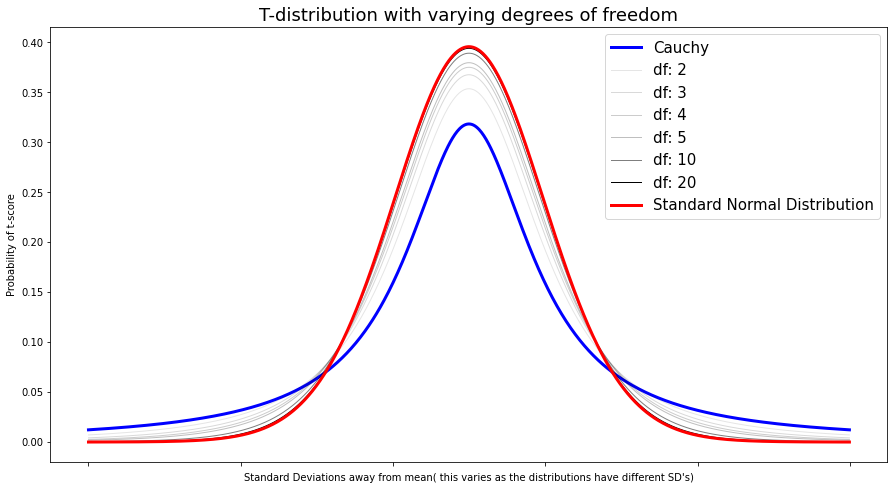

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 8))
cauchy = t_distribution(1)
ax.plot(cauchy, '-', lw=3, alpha=1, label="Cauchy", color='b')
t_df = [2, 3, 4, 5, 10, 20]
for df in t_df:
    dist = t_distribution(df)
    ax.plot(dist, '-', lw=1, alpha=df / 20, label="df: " + str(df), color='k')
gaussian = t_distribution(30)
ax.plot(gaussian,
        lw=3,
        alpha=1,
        color='r',
        label='Standard Normal Distribution')
plt.rcParams.update({"font.size": 15})
ax.set_ylabel("Probability of t-score")
ax.set_xlabel(
    "Standard Deviations away from mean( this varies as the distributions have different SD's)"
)
plt.title("T-distribution with varying degrees of freedom")
ax.set_xticklabels(labels="")
plt.legend()

### T-distribution p-value

As we can see, a lower sample size, and hence a lower degrees of freedom, leads to a lower probaility that our t-score is near 0 when our population means are the same, because more random variation is likely when the sample size is so low. The point of a t-score is to determine if the difference in the two means of the samples is too drastic for the true population means to be the same. As we approach 30 with our degrees of freedom, the graph doesnt change much, and this is a standard normal distribution, which the z-score uses. That is some textbooks say you can use z-score for large sample sizes, it will give nearly the same answer. 

Once we get our t-score based on the t-distribution's cumulative density function, shown below. There is a very tedious calculation we could perform to show this CDF manually and plug our t-stat into it, but for our purposes simply using the scipy library will be sufficient. We get a corresponding __p-value__, shown on the y-axis. This value is the probability of our gotten t-value if the true means were the same. 

- If the corresponding p-value from our t-value is too low, we choose to __reject the null hypothesis $H_o$__, and say that our samples come from different populations who's means are different. This is a "statistically significant" result. 


- If the p-value is sufficiently high, we __fail to reject the null hypothesis $H_o$__, and say that there is a high enough chance that the samples came from populations with the same means. This is a "statistically insignificant" result. 


- The value at which a non-significant result becomes a significant one is called the __*critical value*__, denoted $\alpha$, and is most commonly 0.05.

Next, we can make a master function that uses all of the t-tests we just built:

In [28]:
import scipy.stats as stats

# function that allows us to evaluate the t distribution at a given t value and df
def t_test(a, b, kind):
    
    if kind == 'one_sample': 
            t_val, df = t_value_1samp(a, b)
            print (t_val, df)
    elif kind  == 'independent': 
            t_val, df = t_value_ind_samp(a, b)
    elif kind == 'paired': 
            t_val, df = t_value_ind_samp(a, b, equal_var=True)
            
    # cdf gives probability of a value at least as extreme as observed happening; for two-sided tests this is doubled
    p_value = (1-stats.t.cdf(np.abs(t_val), df))  *2
    
    if p_value > .05:
        return_string = "T-value: " + str(t_val) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
    else:
        return_string = "T-value: " + str(t_val) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."
        
    return return_string

The function accepts $t$ and $\nu$ and returns a probability of the t value occuring if there truly was no difference between the the two sample means, or the single sample mean and one hypothesized mean. If we are intereted in knowing the p that the result is only < or >, we take the p value as is. Otherwise, if we are looking for any difference, we multiply it by 2. If the probability returned is too low, then we can reasonably assume that this means that the two means _are not truly different_. This is the core concept of statistical significance. The probability at which a non-significant difference becomes a significant one is known as the alpha value, and is most commonly 0.05. This means that if there is a less than 5 percent probability that the observed difference in means could have happened by chance, we can reasonably assume that the result didnt happen by chance. 

We can now run the test, comparing the S&P monthly return data to one of the older funds, T. Rowe Price Growth Stock Fund (PRGFX). In order to run the test, the distributions of the data must be normal. We verify this with a historgram prior to running the test: 

<AxesSubplot:>

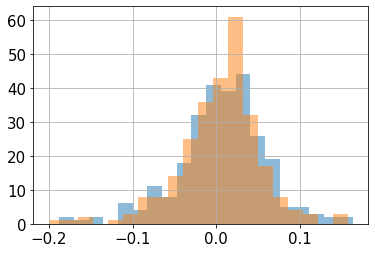

In [29]:
#verify normailty
sp500 = monthly_returns["S&P 500"]
prgfx = monthly_returns["PRGFX"]

prgfx.hist(bins=20, alpha=.5)
sp500.hist(bins=20, alpha=.5)

Since both of these distributions appear roughly normally distributed, we can perform the t-test. 

In [30]:
t_test(prgfx.dropna(), sp500.dropna(), "independent")

'T-value: 0.5636920331368179, P-value: 0.5732005094502304, Fail to reject null hypothesis.'

This can be compared to SciPy's equivalent function: 

In [31]:
stats.ttest_ind(prgfx.dropna(), sp500.dropna())

Ttest_indResult(statistic=0.5626471906571927, pvalue=0.5739095215992591)

This result suggests that the means do not differ. With a high level of confidence, we can reject the hypothesis that one fund has had a higher monthly return than the other. 

Just looking at the means, this makes sense as they are extremely close: 

In [32]:
print(np.mean(sp500), np.mean(prgfx))

0.004784592839126871 0.007250279652615126


In [33]:
keys = monthly_returns.keys()[0:7]

for key in keys: 
    our_t_test = t_test(monthly_returns[key].dropna(), sp500.dropna(), kind='independent')
    scipy_t_test = stats.ttest_ind(monthly_returns[key].dropna(), sp500.dropna())
    print("Our t-test: \n   " + str(our_t_test), 
         "\nScipy t-test: \n   " + str(scipy_t_test))

Our t-test: 
   T-value: 0.5807634649542256, P-value: 0.5616440851965563, Fail to reject null hypothesis. 
Scipy t-test: 
   Ttest_indResult(statistic=0.579686979385639, pvalue=0.5623683894536262)
Our t-test: 
   T-value: 0.7867736891714412, P-value: 0.43176229670700317, Fail to reject null hypothesis. 
Scipy t-test: 
   Ttest_indResult(statistic=0.7853153492908437, pvalue=0.4326143912072242)
Our t-test: 
   T-value: 0.5973153972902862, P-value: 0.550560389920038, Fail to reject null hypothesis. 
Scipy t-test: 
   Ttest_indResult(statistic=0.5935772841322199, pvalue=0.5530564986395465)
Our t-test: 
   T-value: 0.442815075535883, P-value: 0.6580861628889441, Fail to reject null hypothesis. 
Scipy t-test: 
   Ttest_indResult(statistic=0.44001898930614675, pvalue=0.6601086777422075)
Our t-test: 
   T-value: 0.5110869132456151, P-value: 0.6095100937038671, Fail to reject null hypothesis. 
Scipy t-test: 
   Ttest_indResult(statistic=0.5078744785866028, pvalue=0.6117596646739307)
Our t-test:

The results are not exactly the same but they are reasonably close 

# ANOVA 

While using T-tests and Z-tests to analyze means of groups, we were restricted to only being able to compare two groups at a time. What if we wanted to see of there was significant differences between more than two groups? The **ANOVA**, or **Analysis of Variance** techniques allow us to test the null hypothesis that there is no significant difference between $k$ (some integer larger than 2) groups. 

- $H_o$: $\mu_1 = \mu_2 = \cdots = \mu_k$
- $H_a$: At least two of the means are not equal. 

### Assumptions needed for ANOVA
There are three assumptions that must be met in order to carry out an ANOVA test: 

1. The experimental errors of yoyr data are normally distributed
2. Homoscedasticity - the variances of your factors are all roughly the same (and at least follow the same distribution)
3. Samples are independent - Selection of one sample had no effect on any other sample

### F-Statistic
The distribution used for the hypothesis test is a new one. It is called the F distribution, named after Sir Ronald Fisher, an English statistician. The F-statistic is a ratio. There are two sets of degrees of freedom; one for the numerator and one for the denominator. 

The F distribution is derived from the t-distribution. The values of the F distribution are squares of the
corresponding values of the t-distribution. One-Way ANOVA expands the t-test for comparing more than two groups.
The scope of that derivation is beyond the level of this textbook. 

To calculate the F ratio, two estimates of the variance are made:

1. **Variance between samples**: An estimate of $\sigma^2$ that is the variance of the sample means multiplied by n (when the sample sizes are the same.). If the samples are different sizes, the variance between samples is weighted to account for the different sample sizes. The variance is also called **variation due to treatment or explained variation.**

2. **Variance within samples**: An estimate of $\sigma^2$ that is the average of the sample variances (also known as a pooled variance). When the sample sizes are different, the variance within samples is weighted. The variance is also called **the variation due to error or unexplained variation.**

- $SS_b$ = the sum of squares that represents the variation among the different samples

- $SS_w$ = the sum of squares that represents the variation within samples that is due to chance.

To find a "sum of squares" means to add together squared quantities that, in some cases, may be weighted. We used sum of squares to calculate the sample variance and the sample standard deviation. 

MS means "mean square." $MS_b$ is the variance between groups, and $MS_w$ is the variance within groups. These measurements are the total sum of squares of their variances divided by the degrees of freedomom of the measure to give a mean value. 

### Caluculating the F-Statistic

- $k$ = the number of different groups
- $n_j$ = the size of the $j^{th}$ group
- $\bar{x_j}$ = the mean of the $j^{th}$ group
- $\bar{x}$ = the grand mean of all values 
- $N$ = total number of all the values combined (total sample size: $\sum{n_j}$)
- $x_i$ = one value: 

- Explained variation: sum of squares representing variation among the different samples:

    - $SS_{b} = \sum_{j = 1}^{k}{n_j(\bar{x_j} - \bar{x})^2}$

- Unexplained variation: sum of squares representing variation within samples:

    - $SS_w = \sum_{j = 1}^{k}{\sum_{i = 1}^{n_j}{(x_i - \bar{x_j})^2}}$
 
- Total variation across the dataset: 

    - $SS_t = SS_b + SS_w$
    
- $df$'s for the numerator(between samples): $df_b = k – 1$
- $df$'s for the denominator($df$'s within samples): $df_w = k – 1$
- Mean square (variance estimate) explained by the different groups:
$MS_b = \frac{SS_b}{df_b} = \frac{SS_b}{k-1}$
- Mean square (variance estimate) that is due to chance (unexplained): $MS_w = \frac{SS_w}{df_w} = \frac{SS_w}{n - k}$

The one-way ANOVA test depends on the fact that $MS_b$ can be influenced by population differences among means of the several groups. Since $MS_w$ compares values of each group to its own group mean, the fact that group means might
be different does not affect $MS_w$. The null hypothesis says that all groups are samples from populations having the same normal distribution. The alternate
hypothesis says that at least two of the sample groups come from populations with different normal distributions. If the null hypothesis is true, $MS_b$ and $MS_w$ should both estimate the same value. 

Finally, we arrive at the **F-Statistic**, which will function for us as the T-Statistic did earlier this chapter, as an input into its density function to recieve a p-value telling us the likelihood of its occurence if our null hypothesis was true. 

- $ F = \frac{MS_b}{MS_w}$

With a density function:
<h3 align="center">
    <font size="5">
        $ f(x, df_1, df_2) = \frac{df_2^{df_2/2} df_1^{df_1/2} x^{df_1 / 2-1}}
                        {(df_2+df_1 x)^{(df_1+df_2)/2}
                         \beta(df_1/2, df_2/2)}$
    </font>
    </h3> 



where $df_1$ and $df_2$ are the
shape parameters and
$\beta$ is the beta function.  The formula for the beta function
is
<ul>
$B(a, b) = \int_0^1 t^{a-1}(1-t)^{b-1}dt
        = \frac{\Gamma(a)\Gamma(b)}{\Gamma(a+b)}$,
 
<p>where <span class="math notranslate nohighlight">\(\Gamma\)</span> is the gamma function.</p>
    
These funtions could be implemented manually using basic math symbols, but for our purposes, importing them from Scipy will be much more pragmatic. 
    
In a testing context, the F distribution is treated as  "standardized distribution" (i.e., no location or scale parameters).
However, in a distributional modeling context (as with other probability distributions), the F distribution itself can be
transformed with a <a href="eda364.htm">location parameter</a>, $\mu$, and a <a href="eda364.htm">scale parameter</a>, $\sigma$.
<p>

In [34]:
from scipy.stats import f as f_dist

def SSW(*args):
    args = [arg for arg in args]
    ssw = 0
    for arg in args: 
        group_mean = np.mean(arg)
        val = np.sum((arg - group_mean)**2)
        ssw += val
    return ssw

def SSB(*args):
    args = [arg for arg in args]
    ssb = 0
    alldata = np.concatenate(args)
    grand_mean = np.mean(alldata)
    for arg in args: 
        group_mean = np.mean(arg)
        n = len(arg)
        val = n*((group_mean - grand_mean)**2)
        ssb += val

    return ssb

def get_sum_square_stats(*args): 
    """
    Parameters
    ----------------------
    args: array-like
        list of groups to be analyzed. 
        
    Returns
    ------------------
    ssw: float
        Sum-of-squares within the arguments. Tells us how much of the variation
        is due to within-argument variation. 
    
    ssb: Sum-of-squares between arguments. Tells us how much of the variation 
        of the groups is from between-group variation. 
    
    sst: Total sum of squares variation for the list of groups. Tells us how much 
        the samples vary in total. 
        sst = ssw + ssb
    """
    ssw = SSW(*args)
    ssb = SSB(*args)
    sst = ssb + ssw
    return ssw, ssb, sst

def get_anova_counts(args): 
    """
    Parameters
    ----------------------
    args: array-like
        list of groups to be counted. 
        
    Returns
    ------------------
    k: int
        number of groups 
    N: int
        total number of observations across all groups
    dfbn: int
        degrees of freedom between arguments; k - 1
    dfwn: int
        degrees of freedom within arguments; n - 1
    """
    k = len(args)
    N = 0
    for i in range(k):
        N += len(args[i])
    dfbn = k - 1
    dfwn = N - k
    
    return k, N, dfbn, dfwn

def show_distributions(args): 
    anova_df = pd.DataFrame(args)
        #for i in range(k):
         #   arg_df = pd.DataFrame(args[i])
          #  pd.merge(anova_df, arg_df, left_index=False)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        
    i = 1
    for arg in args:
        arg_df = pd.DataFrame(arg)
        arg_df.plot.kde(ax=axs[0], label="Group "+str(i)+ " distribution", legend=True)
        arg_df.plot.hist(ax=axs[0], bins=5, density=True, alpha=0.1)
        i+=1
       
        
        anova_df.transpose().boxplot(grid=False, ax = axs[1])

def finish_anova(f, dfbn, dfwn): 
     """
    Parameters
    ----------------------
    f: float
         calculated f-value. 
         f = mean-square-between groups / mean-square-within groups
         The f-value is the ratio of how much variation is between versus within groups. 
         If the groups means were the same, the between group variation would be zero. 
         As the f-value grows, the more dissimilar the groups means are. 
    dfbn: int
        Degrees of freedom between groups passed to ANOVA funtion. 
    dfwn: int
        Degrees of freedom within groups. 
        
    Returns
    ------------------
    p: float
        p-value calculated from passing gotten f-value and df's into the f-density funtion from scipy. 
        could attempt to manually implement, i.e
        [f(x, df_1, df_2) = (df_2^{df_2/2} df_1^{df_1/2} x^{df_1 / 2-1} / 
        [{(df_2+df_1 x)^{(df_1+df_2)/2}*sc.beta(df_1/2, df_2/2)}\]
        
    return_string: String
        Specifies whether gotten p value implies rejecting or failing to reject the null hypothesis. 
    
    """
    # use scipy to plug f-value into f distribution to return p-value
     p_value = f_dist.sf(dfbn, dfwn, f)
    
     if p_value > .05:
        return_string = "F-value: " + str(f) + ", P-value: " + str(
            p_value) + ", Fail to reject null hypothesis."
     else:
        return_string = "F-value: " + str(f) + ", P-value: " + str(
            round(p_value, 5)) + ", Reject null hypothesis."

     return return_string

In [35]:
# use *args command to accept variable number of arguments
def anova(*args):
    
    k, N, dfbn, dfwn  = get_anova_counts(args)
    
    ssw, ssb, sst = get_sum_square_stats(*args)

    msb = ssb / float(dfbn)
    msw = ssw / float(dfwn)
    f = msb / msw
    
    
    if(show_distributions):
        show_distributions(args)

    return finish_anova(f, dfbn, dfwn)

Now that we have built our function, we can test it. In the case of our mutual fund analysis, a relevant ANOVA problem would be comparing mean returns across the categorical variable of fund category. In one of our data columns, "Morningstar Category", Morningstar provides categorizations of funds based of what they focus on. Does one specialization do better than the others? Should investors choose one category of fund over the others? 

In [36]:
# find what categories are listed in our dataset:
fund_types = mutual_fund_data["Morningstar Category"].unique()
fund_types

array(['Large Growth', 'Large Blend', 'Large Value', 'Mid-Cap Value',
       'Mid-Cap Growth', 'Health', 'Mid-Cap Blend', 'Communications',
       'Small Value'], dtype=object)

In [37]:
# create lists of categories to be analyzed and pull mean yeary returns for each category
fund_type_returns_dict = {}
for ftype in fund_types:
    fund_type_returns_dict[ftype] = []
    for i in range(25, 50):
        if mutual_fund_data["Morningstar Category"][i] == ftype:
            fund_type_returns_dict[ftype].extend(
                monthly_returns[mutual_fund_data["Symbol"][i]])

In [38]:
mutual_fund_data["Morningstar Category"]

0     Large Growth
1     Large Growth
2      Large Blend
3      Large Blend
4      Large Blend
          ...     
95    Large Growth
96    Large Growth
97     Large Value
98     Large Value
99    Large Growth
Name: Morningstar Category, Length: 100, dtype: object

In [39]:
fund_type_returns_dict

{'Large Growth': [nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  nan,
  na

In [40]:
fund_type_returns_dict.keys()

dict_keys(['Large Growth', 'Large Blend', 'Large Value', 'Mid-Cap Value', 'Mid-Cap Growth', 'Health', 'Mid-Cap Blend', 'Communications', 'Small Value'])

There are almost no funds with the last 5 categories so we will just do the analysis on the fist 4. 

'F-value: nan, P-value: nan, Reject null hypothesis.'

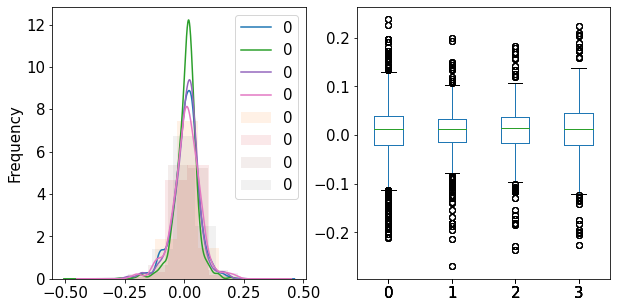

In [41]:
anova(fund_type_returns_dict["Large Growth"],
      fund_type_returns_dict['Large Value'],
      fund_type_returns_dict['Large Blend'],
      fund_type_returns_dict['Mid-Cap Growth'])

Compare to equivalent SciPy function: 

In [42]:
stats.f_oneway(fund_type_returns_dict["Large Growth"],
               fund_type_returns_dict['Large Value'],
               fund_type_returns_dict['Large Blend'],
               fund_type_returns_dict['Mid-Cap Growth'])

F_onewayResult(statistic=nan, pvalue=nan)

These results suggest that almost all of the total variance in the data is caused by within-data variance, not between-data variance. The practical interperetation is that the type of mutual fund does not significantly change yearly returns. This result may support the EMH because specific specialization of funds has no effect on returns. The market gave the same returns to the funds no matter their specialization. 